<a href="https://colab.research.google.com/github/quanvu0996/compet/blob/master/MOA_kaggle_quanvh8_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, DenseFeatures, Dropout, BatchNormalization, Embedding
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC, Precision, Recall
import tensorflow.keras.backend as K
from tensorflow import feature_column as fc
from keras.wrappers.scikit_learn import KerasRegressor

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc, confusion_matrix
from sklearn.utils import check_random_state
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import xgboost as xgb
from lightgbm import LGBMClassifier

%matplotlib inline

In [3]:
print(pd.__version__)
print(tf.__version__)

1.1.3
2.3.0


**Load và clean dữ liệu**

In [6]:
folder_path = '/content/drive/My Drive/Data/colabs_data/MOA_kaggle/'
raw_test = pd.read_csv(folder_path + 'test_features.csv')
raw_train = pd.read_csv(folder_path + 'train_features.csv')
raw_targets = pd.read_csv(folder_path + 'train_targets_scored.csv')

In [12]:
raw_train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [13]:
raw_test.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,-0.2140,0.2221,-0.3260,1.9390,-0.2305,-0.3670,1.3040,1.4610,0.0043,0.6816,-0.2304,-0.0635,-0.2030,-0.6821,-0.6242,0.1297,-0.0338,0.3372,0.2254,0.4795,0.7642,0.6638,-0.2480,-0.1183,-0.4847,-0.0179,-0.8204,-0.5296,-1.5070,-0.0144,...,-0.1353,0.0494,0.8939,0.2270,0.2876,-0.3065,0.6519,-0.8156,-1.4960,0.3796,0.0877,-1.0230,-0.0206,-0.4149,-0.6258,-0.2688,0.4403,-0.4900,0.2910,0.0473,-0.0914,0.3087,-0.0612,-0.9128,-0.9399,0.0173,0.0519,-0.0035,-0.5184,-0.3485,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,-1.8820,0.4022,-0.3528,0.1271,0.9303,0.3173,-1.0120,-0.3213,0.0607,-0.5389,-0.8030,-1.0600,-0.0978,-0.8156,-0.6514,0.6812,0.5246,0.0000,0.5030,-0.1500,-0.1433,2.0910,-0.6556,-0.6012,-0.4104,-0.0580,-0.3608,0.2197,-0.7101,1.3430,...,-0.7458,0.0458,-0.3644,-1.8180,-0.0358,-0.7925,-0.2693,-0.0938,-0.1833,-0.7402,-1.4090,0.1987,0.0460,-1.3520,-0.3445,-0.0909,-0.6337,-0.5788,-0.7885,0.0996,-1.9480,-1.2720,-0.7223,-0.5838,-1.3620,-0.7671,0.4881,0.5913,-0.4333,0.1234,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,-0.3390,-0.3206,0.6944,0.5837,-0.0553,-0.6222,2.5430,-0.7857,0.8163,-0.0495,0.1806,1.0290,-0.5204,-1.1070,0.7365,-0.3835,-0.5771,0.0523,-0.2690,0.1674,0.6010,-0.6660,0.0276,0.0924,0.2785,-0.3943,-0.4602,-0.0673,-1.3420,0.3127,...,0.4369,-1.4960,1.2390,-1.2220,0.6624,-0.7336,-0.5248,0.0727,0.1455,0.5364,-0.0823,0.5734,0.4876,0.7088,1.0750,0.4689,1.0870,-0.5036,-0.3451,0.5087,1.1100,0.7886,0.2093,-0.4617,1.4870,0.1985,1.1750,-0.5693,0.5062,-0.1925,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,0.5998,-0.1799,0.9365,0.2942,1.3990,-1.1080,1.1610,-0.8134,0.0743,-0.3096,-0.9956,1.7100,1.2200,-0.1258,-0.5900,-0.7956,-0.6765,0.0000,-0.8820,0.7609,-0.0882,0.5217,0.9587,-0.4764,0.2690,0.4753,0.0196,0.2775,-0.7142,0.7079,...,-1.2190,-0.5564,-0.2831,0.5902,-0.2881,-0.0013,-0.4036,-0.4076,-0.5593,-0.5505,-0.4806,-0.0846,0.5884,0.2310,0.3956,0.6495,-0.2511,-0.2207,0.1274,-0.5378,0.5649,-0.1231,0.1586,-0.4260,-0.6815,-0.4753,0.2611,-1.1780,0.1909,-1.2320,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,0.5128,0.6365,0.2611,-1.1120,-0.1747,-0.2053,-0.0006,0.0254,0.1784,-0.1314,1.0700,0.0477,-0.0756,0.1287,0.1403,0.7609,-0.1095,0.0000,-1.0950,-0.0780,0.9048,-0.3007,0.4351,-0.1558,0.2101,0.4850,0.1139,0.6745,-0.9101,-0.6690,...,0.6412,0.2123,0.0646,0.5924,0.5284,-0.4421,0.6547,-0.8098,0.9812,-0.0349,0.7816,1.1690,0.4140,1.0250,0.8642,0.5993,0.2091,-0.1521,1.5610,-0.6770,0.3600,-0.1436,-0.0949,1.0640,0.8321,0.9727,-0.5567,0.2240,0.8949,0.8668,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380


In [21]:
raw_targets.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 876 entries, sig_id to c-99
dtypes: float64(872), int64(1), object(3)
memory usage: 159.2+ MB


**Phân loại nhóm dữ liệu tương ứng với hướng xử lý**

In [27]:
# Phân loại dữ liệu
cols_id = ['sig_id']
cols_num = [i for i in raw_train.select_dtypes(include=['float64','int64']).columns if i not in cols_id]
cols_cat = [i for i in raw_train.select_dtypes(include=['object']).columns if i not in cols_id]
cols_target = [i for i in raw_targets.columns if i not in cols_id]
print(cols_num)
print(cols_cat)
print(cols_target)

['cp_time', 'g-0', 'g-1', 'g-2', 'g-3', 'g-4', 'g-5', 'g-6', 'g-7', 'g-8', 'g-9', 'g-10', 'g-11', 'g-12', 'g-13', 'g-14', 'g-15', 'g-16', 'g-17', 'g-18', 'g-19', 'g-20', 'g-21', 'g-22', 'g-23', 'g-24', 'g-25', 'g-26', 'g-27', 'g-28', 'g-29', 'g-30', 'g-31', 'g-32', 'g-33', 'g-34', 'g-35', 'g-36', 'g-37', 'g-38', 'g-39', 'g-40', 'g-41', 'g-42', 'g-43', 'g-44', 'g-45', 'g-46', 'g-47', 'g-48', 'g-49', 'g-50', 'g-51', 'g-52', 'g-53', 'g-54', 'g-55', 'g-56', 'g-57', 'g-58', 'g-59', 'g-60', 'g-61', 'g-62', 'g-63', 'g-64', 'g-65', 'g-66', 'g-67', 'g-68', 'g-69', 'g-70', 'g-71', 'g-72', 'g-73', 'g-74', 'g-75', 'g-76', 'g-77', 'g-78', 'g-79', 'g-80', 'g-81', 'g-82', 'g-83', 'g-84', 'g-85', 'g-86', 'g-87', 'g-88', 'g-89', 'g-90', 'g-91', 'g-92', 'g-93', 'g-94', 'g-95', 'g-96', 'g-97', 'g-98', 'g-99', 'g-100', 'g-101', 'g-102', 'g-103', 'g-104', 'g-105', 'g-106', 'g-107', 'g-108', 'g-109', 'g-110', 'g-111', 'g-112', 'g-113', 'g-114', 'g-115', 'g-116', 'g-117', 'g-118', 'g-119', 'g-120', 'g-121', 

In [ ]:
# # Nhãn
# cols_label = ['label']
# # Đặc trưng binary
# cols_fts_binary = [i for i in train_data.select_dtypes(include=['float64','int64']).columns 
#                    if len(set(train_data[i].fillna(0)) - {0,1} ) == 0 and i not in cols_label]
# # định dang datte yyyy-mm-dd
# cols_date = ['Field_1','Field_2','Field_5','Field_6','Field_7','Field_8','Field_9','Field_11'
#              ,'Field_15','Field_25','Field_32','Field_33','Field_35','Field_40','Field_43','Field_44'
#              ,'F_startDate','F_endDate','E_startDate','E_endDate','C_startDate','C_endDate','G_startDate','G_endDate'
#              ,'A_startDate','A_endDate']
# # định dạng date yyymmdd
# cols_date2 = ['ngaySinh', 'Field_34']
# # Đặc trưng dạng văn bản
# cols_docs = ['Field_46','diaChi','Field_48','Field_49','currentLocationName','homeTownName','Field_56']
# # Định danh bản ghi
# cols_id = ['id','Field_45'] +[i for i in train_data.select_dtypes(include = ['object']).columns 
#                               if len(train_data[i].unique()) >=350 and i not in cols_date + cols_date2+cols_docs]
# # Đặc trưng dạng categorical
# cols_categorical = [i for i in train_data.select_dtypes(include = ['object']).columns
#                     if i not in cols_id + cols_label+cols_date2+cols_date+cols_docs]
# # Đặc trưng số
# cols_fts_num = [ i for i in predict_data.select_dtypes(include=['float64','int64']).columns 
#                 if i not in cols_id + cols_label + cols_fts_binary + cols_date2+cols_date+cols_docs]

In [ ]:
# # Đặc trưng số có dạng như categorical
# cols_num_like_cat = [i for i in cols_fts_num if len(train_data[i].unique()) <= 15 ]
# # Đặc trưng số đã kiểm chứng
# cols_num = [i for i in cols_fts_num if i not in cols_num_like_cat]

# # cols_categorical = list(set(cols_categorical + cols_num_like_cat)) # Không cần thiết, convert qua lại ordinalencoder
# cols_fts_num = [i for i in cols_fts_num if i not in cols_num_like_cat ]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(raw_train
                                                   ,raw_targets
                                                   ,test_size = 0.2
                                                   )

In [17]:
X_train.shape

(19051, 876)

In [39]:
# Simple network to get baseline
baseline_net = Sequential([
            Dense(512, activation='relu'),
            Dense(256, activation='relu'),
            Dense(206, activation='sigmoid')
 ])
baseline_net.compile(loss = 'binary_crossentropy', optimizer= 'adam')

In [41]:
baseline_net.fit( raw_train[cols_num], raw_targets[cols_target],  epochs = 10, batch_size = 1000, validation_split= 0.3 )

Epoch 1/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0167 - val_loss: 0.0178
Epoch 2/10
17/17 [==============================] - 1s 72ms/step - loss: 0.0158 - val_loss: 0.0173
Epoch 3/10
17/17 [==============================] - 1s 74ms/step - loss: 0.0154 - val_loss: 0.0171
Epoch 4/10
17/17 [==============================] - 1s 72ms/step - loss: 0.0152 - val_loss: 0.0170
Epoch 5/10
17/17 [==============================] - 1s 72ms/step - loss: 0.0150 - val_loss: 0.0169
Epoch 6/10
17/17 [==============================] - 1s 72ms/step - loss: 0.0148 - val_loss: 0.0169
Epoch 7/10
17/17 [==============================] - 1s 73ms/step - loss: 0.0146 - val_loss: 0.0168
Epoch 8/10
17/17 [==============================] - 1s 74ms/step - loss: 0.0145 - val_loss: 0.0168
Epoch 9/10
17/17 [==============================] - 1s 73ms/step - loss: 0.0143 - val_loss: 0.0167
Epoch 10/10
17/17 [==============================] - 1s 73ms/step - loss: 0.0141 - val_loss: 0.0166


In [54]:
prediction = baseline_net.predict(raw_test[cols_num])
subittion = np.concatenate([raw_test[cols_id].values, prediction], axis = 1)
np.savetxt("submission.csv", subittion, delimiter=",", fmt='%s')

Test AUC
AUC:  0.7317409842378444
Gini:  0.4634819684756888


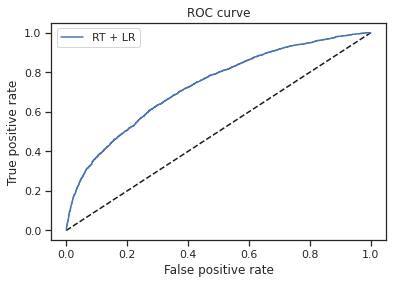

Train AUC
AUC:  0.9443532425103996
Gini:  0.8887064850207993


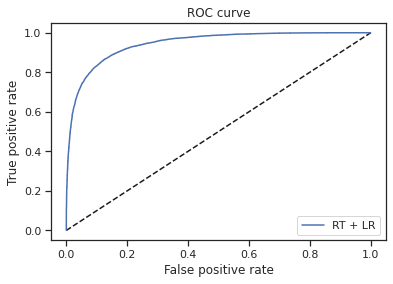

In [ ]:
# Xây dựng pipeline và fit với tree-based
selected_columns = cols_num

class ToString(BaseEstimator, TransformerMixin):
  '''Def 1 trans để convert các cột dạng số như categorical thành dạng cat => dùng được onehot'''
  def fit(self, X, y = None):
    return self
  def transform(self, X, y = None):
    X_ = X.copy() # creating a copy to avoid changes to original dataset
    X_ = X_.astype(str)
    return X_

# Xử lý datetime thành year, month, date như là dạng số - chỉ phù hợp cho tree-based
class DateToNum(BaseEstimator, TransformerMixin):
  def __init__(self, format = '%Y-%m-%d' ):
    self.format = format
  def fit(self, X, y = None):
    return self
  def transform(self, X, y = None):
    X_ = X.copy() # creating a copy to avoid changes to original dataset

    if self.format == '%Y%m%d':
      str_num = 8
    else:
      str_num = 10
    cols = X_.columns
    for i in X.columns:
      X_[i+'year_as_number'] = pd.to_datetime(X_[i].apply(lambda i: str(i)[0:str_num])
                                        , format= self.format , errors= 'coerce').dt.year -2010
      X_[i+'month_as_number'] = pd.to_datetime(X_[i].apply(lambda i: str(i)[0:str_num])
                                        , format= self.format , errors= 'coerce').dt.month
      X_[i+'day_as_number'] = pd.to_datetime(X_[i].apply(lambda i: str(i)[0:str_num])
                                        , format= self.format , errors= 'coerce').dt.day
    X_[cols] = X_[cols].apply(lambda x: ( pd.to_datetime(x.apply(lambda i: str(i)[0:str_num]) , format= self.format , errors= 'coerce')  
                              - pd.to_datetime('20170101', format='%Y%m%d')).apply(lambda x: x.days)
                       , axis = 1)
    return X_

class DocsProcessing(BaseEstimator, TransformerMixin):
  def __init__(self, max_features = None):
    self.max_features_ = max_features
  def fit(self, X, y = None):
    self.X = X.copy()
    try:
      self.X['docs_combine_all_column'] = ''
    except:
      self.X = pd.DataFrame(data= self.X)
      self.X['docs_combine_all_column'] = ''
    for i in self.X.columns:
      self.X['docs_combine_all_column'] += self.X[i]
    self.tokenizer = CountVectorizer(max_features = self.max_features_)
    self.tokenizer.fit(self.X['docs_combine_all_column'])
    return self

  def transform(self, X, y = None):
    return self.tokenizer.transform(self.X['docs_combine_all_column']).todense()

# docs_pipe= Pipeline([
#       ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))
#     , ('to_string', ToString())
#     , ('vectorize', DocsProcessing(max_features = 512))
# ])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))
    , ('to_string', ToString())
    , ('encode', OneHotEncoder(handle_unknown='ignore')) #OrdinalEncoder(categories=categories_val))
])

ordinal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value= -1 ))
    , ('standard', StandardScaler()) # Với tree thì không cần standard
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
    , ('standard', StandardScaler()) # Với tree thì không cần standard
])

binary_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value= -1 ))
    , ('standard', StandardScaler()) # Với tree thì không cần standard
])

datetime_pipe1 = Pipeline([
    ('datetime1', DateToNum(format='%Y-%m-%d'))
    , ('imputer', SimpleImputer(strategy='median'))
    , ('standard', StandardScaler()) # Với tree thì không cần standard
])

datetime_pipe2 = Pipeline([
    ('datetime2', DateToNum(format='%Y%m%d'))
    , ('imputer', SimpleImputer(strategy='median'))
    , ('standard', StandardScaler()) # Với tree thì không cần standard
])

preprocessing = ColumnTransformer(
    [
    #  ('docs', docs_pipe, cols_docs),
     ('cat', categorical_pipe, cols_categorical),
     ('ordinal', ordinal_pipe, cols_num_like_cat),
     ('num', numerical_pipe, cols_fts_num), 
     ('binary', binary_pipe, cols_fts_binary), 
     ('date1', datetime_pipe1, cols_date),
     ('date2', datetime_pipe2, cols_date2)
     ])

#xgb.XGBRegressor(objective="reg:linear", random_state=42, n_estimators =64, max_depth =7)
# LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=128,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1
#         )
model = GradientBoostingClassifier(random_state=42, max_depth = 8 , n_estimators = 200
                                   , subsample = 0.5 ) #min_samples_leaf =100   , loss = 'exponential' )

pipe = Pipeline([
    ('preprocess', preprocessing),
    # ('pca', PCA(n_components = 150)),
    ('classifier', model)
])

pipe.fit(X_train[selected_columns], y_train)

def evaluate_model(model, X, y):
  try:
    y_pred = model.predict_proba(X)[:, 1]
  except:
    y_pred = model.predict(X)

  fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y, y_pred)
  auc_s = auc(fpr_rt_lm, tpr_rt_lm)
  print('AUC: ', auc_s)
  print('Gini: ', 2*auc_s - 1)

  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()
print('Test AUC')
evaluate_model(pipe, X_test[selected_columns], y_test)

print('Train AUC')
evaluate_model(pipe, X_train[selected_columns], y_train)


Dự đoán kết quả

In [ ]:
try:
  prediction = pipe.predict_proba(predict_data[selected_columns])[:, 1]
except:
  prediction = pipe.predict(predict_data[selected_columns])
res_df = pd.DataFrame({'id': predict_data.id, 'label': prediction})
res_df.to_csv('submission.csv', index=False)